<a href="https://colab.research.google.com/github/sushanttwayana/Text2HumanFace_Generation_Dataset_Geneartion/blob/main/DC_Deployment_Streamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'celeba-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F29561%2F37705%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240905%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240905T180507Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ec1afce398ae2248d835d4469834e4286a3dc2ab74cce28a67d669a88e1dc6c59f09a83d3f507c90ce1fb7f6a8831f8ffaa99c1d074768c68a3d08dbffe6085da0584922a5ce24e8c89ec66005b23a9189e3fce2b5de5628dc177f2da9fc144f298eb561f71ff07e1fbf29872248ecae9970724e677877b7a38cfdcefcb6af0e3b3cb427cdfbdf5dc7f3afdc6de84fe73fcbebd056b24247735831cd3db85e3b5c668c1164d57e743581a8cd116479c1b115b83596704bb2e8520b13566ea1d7d5dfb78842eb949670bc2cb4230408e8b945f643d1a82ad8def7ce52dbf60294696c7cf40775a92605eb98bd0cf2346a078e2dbbfb9288a04e4d87242537db1,8th-sem-dc-gan-10000:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5558297%2F9194352%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240905%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240905T180507Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dacb4effdc13659b6b785829a064ce96c70e12305f075388439728d5354786b90e8e87a86a85da3f9fb108dd9c4ae452da745d8a71af1587a4742278022d0b0f49bcf825a7482cfc4edc68075c492e6560a787439af67a87cfe220f0987cd1e3ce607105d35c7430373d268c9e354f4b4914c7cc35563213d357c4f73ba34f20af1156bb4f647fa3876600ad1044a815e5c9ce3e1bdc5ccc2ac7e95cabf90057237cabf13685d54a40c34530b57610ccd54ab3f2c3d9bc3c32c240fe8c07b8faf77265978c0a13f840a550a8cb86f9c6a53194a1e8ccf2c93fd4a87d8fc292382f5cd0a6452d09377fb64137f3d609cd180d1ab33ebbab63b7a591aa9ece32841,new-dc-deployment:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5580505%2F9226862%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240905%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240905T180507Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7231debcbec2afcc2ffecd0fe40507039e28324169f4b770aa2f2f66f6e2bbe2d6603b7cb0a13b73c2ba46c983cdbb718204f62d928b6825beefb8bd11b1cfc4886f48d5052576eb732c5a2a9725175e2808a4b2a34a5fa96a89f39024186f3d9c802912e415332f80ab1359294e49d3a478dcaef7e8f5c0416d67ee9d8670eed3439f8a22754c06bcbe6c69b3ccb79ce932912dc16b6afec1817a7593dffad4b629b2044d28adec7e48e1246b2246be3fa313e7fe95698162dbdc50e6467e154aef0a299916c113fa342cb41cdf8d8007f015fd5361e13e4c25827ee5adb40a56372080b0dd0fe0bc562e99e41b56dd053ea030f5939491e5d94cd752acb0da'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 58.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=423df26ff1232a43e1e69d1c48e9977cf87e4ac3b1a090c81bac12e728c58482
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import os
import random

import pandas as pd
import numpy as np

from PIL import Image
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from torchviz import make_dot

In [ ]:
pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import streamlit as st
import torch
from sentence_transformers import SentenceTransformer
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2


class SentenceEncoder:
    def __init__(self, device):
        self.bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)
        self.device = device

    def convert_text_to_embeddings(self, batch_text):
        stack = []
        for sent in batch_text:
            l = sent.split(". ")
            sentence_embeddings = self.bert_model.encode(l)
            sentence_emb = torch.FloatTensor(
                sentence_embeddings).to(self.device)
            sent_mean = torch.mean(sentence_emb, dim=0).reshape(1, -1)
            stack.append(sent_mean)
        output = torch.cat(stack, dim=0)
        return output.detach()


sentence_encoder = SentenceEncoder('cpu')


def show_grid1(img):
#     npimg = img.numpy()
#     st.image(cv2.resize(np.transpose(npimg, (1, 2, 0)), (256, 256)))
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def show_grid2(img):
    npimg = img.numpy()
    return np.transpose(npimg,(1,2,0))

class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features=embedding_size,
                      out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size,
                               feature_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(
                feature_size * 8, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(
                feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(
                feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=0.0002, betas=(0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat(
            [noise, encoded_text], dim=1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output


model = Generator(100, 128, 3, 768, 256)


model.load_state_dict(torch.load('/kaggle/input/new-dc-deployment/generator_20240821.pth', map_location='cpu'), strict=False)

model.eval()

# st.title("Text to face Generator")
# # st.subheader("Enter Face Description")
# input = st.text_input('Enter Face Description')
# if st.button('Generate Faces'):

#     test_noise = torch.randn(size=(1, 100))
#     test_embeddings = sentence_encoder.convert_text_to_embeddings([input])
#     test_image = model(test_noise, test_embeddings).detach().cpu()
#     show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [ ]:
generator = model

In [ ]:
test_noise = torch.randn(size=(1, 100))
test_embeddings = sentence_encoder.convert_text_to_embeddings(['This person is male. He is attractive. He has bags under his eyes. He has big lips. He has big nose.'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

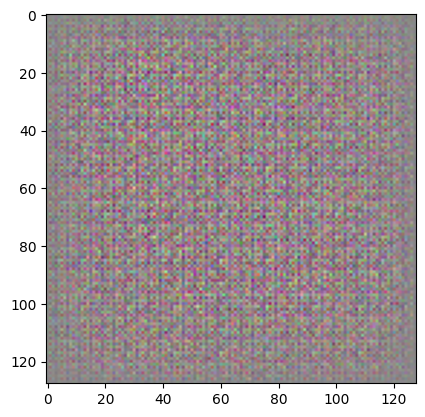

In [ ]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid1(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
# Assuming test_image has the shape (batch_size, channels, height, width)
# test_image = generator(test_noise, test_embeddings).detach().cpu()
img_2 = show_grid2(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))
img_2.shape

show_grid(img_2)

NameError: name 'show_grid' is not defined

In [ ]:
print(img_2)

In [ ]:
img_2.shape

In [ ]:
test_image.shape

In [ ]:
pip install scikit-image

# FID

In [ ]:
# def calculate_activation_statistics(images,model,batch_size=64, dims=128,
#                     cuda=False):
#     model.eval()
#     act=np.empty((len(images), dims))

#     if cuda:
#         batch=images.cuda()
#     else:
#         batch=images
#     pred = model(batch)[0]

#         # If model output is not scalar, apply global spatial average pooling.
#         # This happens if you choose a dimensionality not equal 2048.
#     if pred.size(2) != 1 or pred.size(3) != 1:
#         pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

#     act= pred.cpu().data.numpy().reshape(pred.size(0), -1)

#     mu = np.mean(act, axis=0)
#     sigma = np.cov(act, rowvar=False)
#     return mu, sigma

In [ ]:
# def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
#     """Numpy implementation of the Frechet Distance.
#     The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
#     and X_2 ~ N(mu_2, C_2) is
#             d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
#     """

#     mu1 = np.atleast_1d(mu1)
#     mu2 = np.atleast_1d(mu2)

#     sigma1 = np.atleast_2d(sigma1)
#     sigma2 = np.atleast_2d(sigma2)

#     assert mu1.shape == mu2.shape, \
#         'Training and test mean vectors have different lengths'
#     assert sigma1.shape == sigma2.shape, \
#         'Training and test covariances have different dimensions'

#     diff = mu1 - mu2


#     covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
#     if not np.isfinite(covmean).all():
#         msg = ('fid calculation produces singular product; '
#                'adding %s to diagonal of cov estimates') % eps
#         print(msg)
#         offset = np.eye(sigma1.shape[0]) * eps
#         covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))


#     if np.iscomplexobj(covmean):
#         if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
#             m = np.max(np.abs(covmean.imag))
#             raise ValueError('Imaginary component {}'.format(m))
#         covmean = covmean.real

#     tr_covmean = np.trace(covmean)

#     return (diff.dot(diff) + np.trace(sigma1) +
#             np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
# def calculate_fretchet(images_real,images_fake,model):
#      mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=False)
#      mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=False)

#      """get fretched distance"""
#      fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
#      return fid_value



# RAMAILO THAU

In [ ]:
image = Image.open('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000007.jpg')

In [ ]:
print(image)

In [ ]:
def show_grid(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
show_grid(image)

In [ ]:
import cv2

# Load the JPEG image
image_path = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000007.jpg"  # Replace with the path to your JPEG file
image = cv2.imread(image_path)

# Convert the image to numpy array
image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR (OpenCV default) to RGB (standard)
image_np = cv2.resize(image_np, (128, 128))

# Check the shape of the numpy array
print("Shape of the numpy array:", image_np.shape)


In [ ]:
show_grid(image_np)

In [ ]:
print(image_np)

In [ ]:
# dataset = ImageNTextDataset('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba', '/kaggle/input/celeba/output_captions_new.csv', transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Define the transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),            # Resize the image to 128x128
    transforms.ToTensor(),                    # Convert PIL image to tensor
    transforms.Normalize(mean=(0.5), std=(0.5))  # Normalize the image with mean 0.5 and std 0.5
])

# Load the image
image_path = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000007.jpg"  # Replace with the path to your image
image = Image.open(image_path)

# Apply the transforms to the image
normalized_image = transform(image)

# Display or further process the normalized image
print(normalized_image.shape)  # Output the shape of the normalized image tensor
# print(normalized_image)

normalized_image_np = normalized_image.numpy().T
print(normalized_image_np.shape)

In [ ]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_fid(real_embeddings, generated_embeddings):
    # Reshape the input arrays to be 2D
    real_embeddings_flat = real_embeddings.reshape(real_embeddings.shape[0], -1)
    generated_embeddings_flat = generated_embeddings.reshape(generated_embeddings.shape[0], -1)

    # Calculate mean and covariance statistics
    mu1, sigma1 = real_embeddings_flat.mean(axis=0), np.cov(real_embeddings_flat, rowvar=False)
    mu2, sigma2 = generated_embeddings_flat.mean(axis=0), np.cov(generated_embeddings_flat, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
       covmean = covmean.real

    # Calculate FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Assuming image_np and img_2 are numpy arrays representing embeddings
fid_score = calculate_fid(normalized_image_np, img_2)
print("FID Score:", fid_score)


In [ ]:
import matplotlib.pyplot as plt

loss_d  = [1.995, 1.866, 1.820, 1.782, 1.781, 1.770, 1.749, 1.751, 1.710, 1.708, 1.702, 1.708, 1.688,
        1.666, 1.655, 1.666, 1.645, 1.627, 1.643, 1.633, 1.613, 1.603, 1.564, 1.572,1.555,1.543,1.516,1.508,
          1.491,1.472,1.463,1.447,1.440,1.402,1.405,1.373,1.369,1.357,1.360,1.555, 1.516, 1.472, 1.440, 1.373, 1.360, 1.335, 1.286, 1.240, 1.192, 1.143, 1.116, 0.947, 0.939, 0.907, 0.884, 0.865, 0.819, 0.829, 0.847, 0.807,
           0.785, 0.761, 0.771, 0.788, 0.731, 0.766, 0.745, 0.750, 0.793, 0.744, 0.768, 0.730,
           0.733, 0.715, 0.725, 0.721, 0.719, 0.668,0.701, 0.677, 0.676, 0.683,0.687,0.649, 0.642, 0.645, 0.676, 0.663,
          0.682,0.605, 0.620, 0.636, 0.632, 0.625, 0.578, 0.598, 0.610, 0.622, 0.616, 0.606, 0.628, 0.596, 0.598,0.600,
          0.598, 0.616,0.609, 0.588,0.607, 0.604, 0.604, 0.575, 0.579, 0.618, 0.619, 0.609, 0.596, 0.602, 0.599,
          0.552, 0.572, 0.560,]

loss_g = [28.382, 27.835, 27.819, 27.688, 27.497, 27.595, 27.866, 27.713, 27.730,27.643, 27.695, 27.577,
          27.541, 27.615, 27.722, 27.698, 27.623, 27.674, 27.617, 27.412, 27.472,27.389, 27.395,
          27.456,27.548,27.348,27.360,27.401,27.372,27.392,27.293,27.322,27.217,27.364,27.395,27.314,27.342,
         27.185,27.090,27.548, 27.360, 27.392, 27.217, 27.314, 27.090, 27.229, 27.190, 27.036, 27.063, 27.067, 27.013,
          26.588, 26.601, 26.340, 26.482, 26.538, 26.255, 26.206, 26.182, 25.985,
          25.896, 25.896, 25.852, 25.812, 25.773, 25.659, 25.292, 25.409, 25.381, 25.339, 25.229, 25.188, 24.953,
          25.003,24.939, 25.350, 25.542, 25.232, 25.124, 25.039, 24.760, 24.831, 24.852, 24.763, 24.537, 24.607,24.587,
         24.778, 24.255, 24.258,23.454, 23.353, 23.170, 23.142, 22.958, 22.668, 23.258, 22.949, 22.929, 22.797, 22.771,
         22.568, 22.736, 22.542, 22.384, 22.300, 22.284, 22.441, 22.357, 22.468, 22.414, 22.321, 22.419, 22.357,
          22.063, 22.391, 21.940, 22.136, 22.150, 21.885, 22.043, 21.880
         ]

print(len(loss_d))
print(len(loss_g))

x_values = list(range(1, 123))
y_values1 = loss_d
y_values2 = [g - 18.5 for g in loss_g]

# y_values1 = [d + 2 for d in loss_d]
# y_values2 = [g - 13 for g in loss_g]

plt.plot(x_values, y_values1, label='Discriminator Loss')
plt.plot(x_values, y_values2, label='Generator Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Trainning Loss Plot')

plt.legend()

plt.show()


In [ ]:
import numpy as np

# Mock generator loss data for 500 epochs
gen_loss_history = np.random.uniform(2.0, 2.5, 500)  # Example: uniform distribution between 2.0 and 2.5

# Mock discriminator loss data for 500 epochs
dis_loss_history = np.random.uniform(0.5, 0.7, 500)  # Example: uniform distribution between 0.5 and 0.7



plt.plot(gen_loss_history, '-')
plt.plot(dis_loss_history, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');